In [1]:
import cv2
import os
import pandas as pd 
import numpy as np
import re
import pickle

In [2]:
fixed_size = tuple((500, 500))
contrast_range=0.95

In [3]:
conspiracyVideo = pd.read_excel("COVID19_youtube_dataset.xlsx", usecols="A,P,Q")

In [4]:
listing = os.listdir("./covid2_images")
listing 

['CUIXYlf8euY',
 'kucORiTPSj0',
 'CyriDJdvByg',
 'tS7fwVuDbBI',
 'NCIC97pwsGQ',
 'C3ldtVWKlQI',
 'mK-jGzhCQOM',
 'gxK663VZALI',
 'SkT0uIUSdWs',
 '1tEVKhdj0I0',
 '4L8LqsDE5KQ',
 'NJ25CwmXRCk',
 'WlcUEHvlpP4',
 '4zPr_h8BCZo',
 'jGercZqwc1E',
 'QnB78znNYO8',
 'QgCP5XmoQVg',
 '3MYJsQ6jTpY',
 'YsqRf0fujN4',
 'Bsz3PtLoqfY',
 '87VJMp8Tz-g',
 'Bp29PXsO5MU',
 '72d0BGPXcCI',
 '0L6PN-wYi8I',
 'fUo1w5aSkro',
 '_HeXw38cGZc',
 'GS65CBYG1Ts',
 '2MGXePjIzXE',
 'BmAHknyL0x8',
 'C6LRIkl777Q',
 'kr-AWnDZZtQ',
 'id4S4ge2bCQ',
 'LQnmYRWT_bA',
 '4zk_6doQ480',
 'LzHS1B1Gjqg',
 'F9rrgYaekFI',
 'ruoq7olr21Q',
 'EALuXH_Lw2U',
 '.DS_Store',
 'n8hwiV6XEi0',
 'EsgdrL8KKjg',
 'bIeoSqpbj9Y',
 'S8uuYXOtKUQ',
 'x1SP0AgbR38',
 'fOjp8Eg3Htc',
 'y28irzZcWa0',
 'eWHPaghHpbk',
 'k-xp2jkh4v4',
 'I0nGvAiail0',
 'c6abF8eqgGY',
 'y2oML9BpQ5g',
 'UG_c-yI01Tg',
 'ttAM_aFvKGY',
 'w77UA20sjoY',
 'MBTBFZ0_Jek',
 'ab-r0capbzk',
 'hPHq2hFT3w0',
 'NDnjXdDxEhk',
 'j5h9ESopElA',
 'uZUJhKUbd0k',
 '7ljBjmVMTSk',
 'RCOlw_yBt8o',
 'HkveLxYU

In [6]:
rootdir = "./covid2_images"
def frame(x):
    return int(re.findall('[0-9]+', x)[0])


In [7]:
def getConspiracy(videoId):
    row = conspiracyVideo.loc[conspiracyVideo['video_id']==videoId,'Attitude']
    if row.empty:
        return None 
    return 1 if row.values[0] == 1 else 0

In [9]:
dictOfVideo = {} ##Make a Dictionary
for subdir, dirs, files in os.walk(rootdir):
    
     ##OR it can equal the input of something, up to you.
    df = pd.DataFrame(columns = ['frame','r_mean', 'g_mean', 'b_mean',
                                 'h_mean','s_mean','v_mean',
                                'brightness','lightning','contrast','colorfulness']) 
    
    for file in files:
        # read the image and resize it to a fixed-size
#         print(subdir)
        name = str(subdir).split('/')
        video = name[len(name)-1]
#         print(video)
        dir = subdir + "/" + file
#         print(file)
        try:
#             rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#             rgbR, rgbG, rgbB = np.mean(rgb, axis = (0,1))
            img = cv2.imread(dir)
            img = cv2.resize(img, fixed_size)
            
            rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

            ####################################
            # Global Feature extraction
            ####################################
            rgbR, rgbG, rgbB = np.mean(rgb, axis = (0,1))
            hue, saturation, value = np.mean(hsv, axis = (0,1))
            
            # colorfulness
            rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            rgb = rgb.astype(float) # OpenCV reads image in unit8 (range 0-255), so first converts to float
            l_rgbR, l_rgbG, l_rgbB = cv2.split(rgb) # get lists of R, G, B values
            l_rg = l_rgbR - l_rgbG
            l_yb = 0.5*l_rgbR  + 0.5*l_rgbG - l_rgbB
            rg_sd  = np.std(l_rg); rg_mean = np.mean(l_rg)
            yb_sd  = np.std(l_yb); yb_mean = np.mean(l_yb)
            rg_yb_sd = (rg_sd**2 + yb_sd**2)**0.5
            rg_yb_mean = (rg_mean**2 + yb_mean**2)**0.5
            colorful = rg_yb_sd + (rg_yb_mean * 0.3)
            
             # brightness
            gray = cv2.imread(dir, 0)
            gray = cv2.resize(gray, fixed_size)
            bright = np.mean(gray) # brightness
            bright_sd = np.std(gray)
            
             # contrast
            hist = np.bincount(gray.ravel(),minlength=256) # create a histogram of brightness values
            sum = np.sum(hist) # get sum of the histogram
            p = (1 - contrast_range)/2;  q = (1 + contrast_range)/2
            low_sum = sum * p; high_sum = sum * q
            cumsum = np.cumsum(hist)
            low_idx = (np.abs( cumsum - low_sum )).argmin() # find a range that covers (q-p) percent of the histogram
            high_idx = (np.abs( cumsum - high_sum )).argmin()
            contrast = high_idx - low_idx
                
            
            df_length = len(df)
            df.loc[df_length] = np.concatenate((frame(file),rgbR, rgbG, rgbB,hue, saturation, value,
                                               bright,bright_sd,contrast,colorful), axis=None)
            
            
        except cv2.error as e:
            print('Invalid frame!')
            
        
        
    print("[STATUS] processed folder: {}".format(subdir))
    if not df.empty:
        df = df.sort_values(by=['frame'])
        df['frame_index'] = range(len(df))
        dictOfVideo[video] = df
print("[STATUS] completed Global Feature Extraction...")
with open('new2.pickle', 'wb') as handle:
    pickle.dump(dictOfVideo, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
design_matrix = pd.DataFrame(columns = ['videoid','conspiracy','var_r','var_g','var_b',
                                       'var_h','var_s','var_v',
                                       'var_bright','var_bright_sd','var_contrast','var_colorful',
                                        'median_r','median_g','median_b','median_h',
                                        'median_s','median_v','median_bright','median_bright_sd',
                                       'median_contrast','median_colorful',
                                        'r_mean','g_mean','b_mean','h_mean','s_mean','v_mean','bright_mean','lightning_mean',
                                       'contrast_mean','colorful_mean'])

for i,id in enumerate(dictOfVideo):
    df_length = len(design_matrix)
    df = dictOfVideo[id]
    #get meta-data
    conspiracy_type = getConspiracy(id)
    r_var = df['r_mean'].var()
    g_var = df['g_mean'].var()
    b_var = df['b_mean'].var()
    h_var =df['h_mean'].var()
    s_var =df['s_mean'].var()
    v_var =df['v_mean'].var()
    bright_var =df['brightness'].var()
    ligiht_var =df['lightning'].var()
    contrast_var =df['contrast'].var()
    colorful_var =df['colorfulness'].var()
    
    r_median = df['r_mean'].median()
    g_median = df['g_mean'].median()
    b_median = df['b_mean'].median()
    h_median =df['h_mean'].median()
    s_median =df['s_mean'].median()
    v_median =df['v_mean'].median()
    bright_median =df['brightness'].median()
    ligiht_median =df['lightning'].median()
    contrast_median =df['contrast'].median()
    colorful_median =df['colorfulness'].median()
    
    r_mean = df['r_mean'].mean()
    g_mean = df['g_mean'].mean()
    b_mean = df['b_mean'].mean()
    h_mean =df['h_mean'].mean()
    s_mean =df['s_mean'].mean()
    v_mean =df['v_mean'].mean()
    bright_mean =df['brightness'].mean()
    ligiht_mean =df['lightning'].mean()
    contrast_mean =df['contrast'].mean()
    colorful_mean =df['colorfulness'].mean()
    
    
    design_matrix.loc[df_length] = np.concatenate(( id, conspiracy_type,
                                                  r_var,g_var,b_var,h_var,s_var,v_var,
                                                  bright_var, ligiht_var,contrast_var,colorful_var,
                                                   r_median,g_median,b_median,h_median,s_median,v_median,
                                                  bright_median, ligiht_median,contrast_median,colorful_median,
                                                   r_mean,g_mean,b_mean,h_mean,s_mean,v_mean,bright_mean,ligiht_mean,
                                                   contrast_mean,colorful_mean
                                                  ), axis=None)
design_matrix.to_csv("new2.csv")
    

Invalid frame!
[STATUS] processed folder: ./covid2_images
[STATUS] processed folder: ./covid2_images/CUIXYlf8euY
[STATUS] processed folder: ./covid2_images/kucORiTPSj0
[STATUS] processed folder: ./covid2_images/CyriDJdvByg
[STATUS] processed folder: ./covid2_images/tS7fwVuDbBI
[STATUS] processed folder: ./covid2_images/NCIC97pwsGQ
[STATUS] processed folder: ./covid2_images/C3ldtVWKlQI
[STATUS] processed folder: ./covid2_images/mK-jGzhCQOM
[STATUS] processed folder: ./covid2_images/gxK663VZALI
[STATUS] processed folder: ./covid2_images/SkT0uIUSdWs
[STATUS] processed folder: ./covid2_images/1tEVKhdj0I0
[STATUS] processed folder: ./covid2_images/4L8LqsDE5KQ
[STATUS] processed folder: ./covid2_images/NJ25CwmXRCk
[STATUS] processed folder: ./covid2_images/WlcUEHvlpP4
[STATUS] processed folder: ./covid2_images/4zPr_h8BCZo
[STATUS] processed folder: ./covid2_images/jGercZqwc1E
[STATUS] processed folder: ./covid2_images/QnB78znNYO8
[STATUS] processed folder: ./covid2_images/QgCP5XmoQVg
[STATUS

[STATUS] processed folder: ./covid2_images/O6g2HBm9qKQ
[STATUS] processed folder: ./covid2_images/R6y8dlhoMpo
[STATUS] processed folder: ./covid2_images/6ZwEzx0WiI0
[STATUS] processed folder: ./covid2_images/De2ydH6qQlg
[STATUS] processed folder: ./covid2_images/HM_aUduXK-U
[STATUS] processed folder: ./covid2_images/vl6ue4aw9hE
[STATUS] processed folder: ./covid2_images/RxTX1lUpAYs
[STATUS] processed folder: ./covid2_images/xmoTebYF90w
[STATUS] processed folder: ./covid2_images/Lr1coQvPtDY
[STATUS] processed folder: ./covid2_images/fyyw_alZ_yk
[STATUS] processed folder: ./covid2_images/0zP5AXq95Fc
[STATUS] processed folder: ./covid2_images/bcvJjRHqMPg
[STATUS] processed folder: ./covid2_images/ijGZoGVS3tA
[STATUS] processed folder: ./covid2_images/XpLiQ6Ujq0c
[STATUS] processed folder: ./covid2_images/n_P6wU_8bS0
[STATUS] processed folder: ./covid2_images/wGRf1b9dPqo
[STATUS] processed folder: ./covid2_images/_3arIvq07J0
[STATUS] processed folder: ./covid2_images/FOvNHBn9rBQ
[STATUS] p

In [6]:
dictOfVideo['8JzQ-Fudhdk']

,frame,r_mean,g_mean,b_mean,r_median,g_median,b_median,h_mean,s_mean,v_mean,frame_index
1396,29.0,100.617084,81.349760,79.292568,100.0,81.0,57.0,97.294044,114.805580,113.013716,0
1662,58.0,100.219624,81.467200,79.039776,99.0,81.0,58.0,96.545636,116.147876,112.886832,1
199,87.0,99.157724,80.831152,78.509688,97.0,80.0,57.0,96.153988,116.871728,111.995336,2
1439,116.0,98.728812,80.577876,78.228632,96.0,79.0,56.0,95.745192,116.836500,111.660872,3
84,145.0,98.541280,80.519772,77.745372,97.0,79.0,56.0,95.354524,117.155524,111.365480,4
...,...,...,...,...,...,...,...,...,...,...,...
594,58058.0,4.485236,4.434984,5.813060,1.0,1.0,1.0,7.546028,15.738796,6.086236,2001
1025,58087.0,4.405596,4.397868,5.894668,1.0,1.0,1.0,7.531700,15.783456,6.091228,2002
823,58116.0,4.371776,4.422416,5.942640,1.0,1.0,1.0,7.375988,15.590552,6.135272,2003
1721,58145.0,4.360540,4.416596,5.966192,1.0,1.0,1.0,6.929188,14.753916,6.153056,2004


In [7]:

with open('pilot_conspiracy_video.pickle', 'wb') as handle:
    pickle.dump(dictOfVideo, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [11]:
conspiracyVideo = pd.read_excel("COVID19_youtube_dataset.xlsx", usecols="A,P,Q")

In [10]:
design_matrix = pd.DataFrame(columns = ['videoid','conspiracy','var_r','var_g','var_b',
                                       'var_s'])

for i,id in enumerate(dictOfVideo):
    df_length = len(design_matrix)
    df = dictOfVideo[id]
    #get meta-data
    conspiracy_type = getConspiracy(id)
    r_var = df['r_mean'].var()
    g_var = df['g_mean'].var()
    b_var = df['b_mean'].var()
    s_var =df['s_mean'].var()
    
    design_matrix.loc[df_length] = np.concatenate(( id, conspiracy_type,
                                                  r_var,g_var,b_var,s_var), axis=None)
    
    

NameError: name 'dictOfVideo' is not defined

In [78]:
type(design_matrix)

pandas.core.frame.DataFrame

In [13]:
design_matrix.to_csv("pilot_color_feature.csv")

In [20]:
design_matrix

,videoid,conspiracy,mean_r,mean_g,mean_b,var_r,var_g,var_b,mean_s,var_s
0,VSzpdzidqJw,1,136.1319307402032,129.29244526560234,126.91875332365747,811.8285720790838,1056.2529618353412,1519.1172143562394,52.61003071698113,2109.5361837080313
1,Bv2T0YkjVzU,1,112.47254722807017,79.80519936842106,129.2782565614035,1469.888196462362,3308.266627984671,7109.363681524339,178.66531340350878,4141.512088711482
2,Kh-N0gAoWbc,1,99.00610334183955,92.79234461289249,92.11877102673915,619.3442934213508,440.3311001613859,419.4786987007804,88.64596330189725,557.6411716242732
3,VJGzxBRYRms,1,55.16679991061453,69.87386578026072,63.678621191806336,226.8484322288862,321.0592456657459,250.14598379408156,71.53363479329609,663.765147015845
4,AXxObR7wJ90,1,172.5572102110553,172.46011326633166,174.9094687839196,2097.2076098722882,2093.061951852732,1779.3104592970487,22.781773688442208,183.32094847863894
5,PSLU30p_ZW8,0,119.81100335795455,120.3383067556818,124.60273048295453,741.8961559298646,744.4843808635886,722.7976840059357,22.831938784090912,111.90681654422855
6,4Hcwdd4eK5s,0,144.4091510234114,140.9285269966555,172.92039673578594,18.55037383390666,8.029142570384899,8.75757130529334,67.45076160535116,8.782043605820238
7,zcMaTrPdeU4,1,118.38562291764704,121.09143687058824,129.56472168235294,2897.2119374675185,2789.974896848003,2586.7437255528926,46.76942951764706,1816.8385056261234
8,XvDKLr47LF4,1,144.38456793220337,145.97766752542373,144.4234053559322,267.9146451891401,263.2559415462053,538.6190768863898,61.11184833898305,948.6814971881669
9,zaoRCI_TyAg,0,90.69830819379845,81.86536294573644,103.11832651937985,4899.812146366353,5638.860166366851,5465.818101787808,135.11460490697678,6480.802834635895


In [17]:
import numpy as np
import pandas as pd
import scipy.stats as stats

In [24]:
design_matrix[design_matrix['conspiracy']=='0']

,videoid,conspiracy,mean_r,mean_g,mean_b,var_r,var_g,var_b,mean_s,var_s
5,PSLU30p_ZW8,0,119.81100335795455,120.3383067556818,124.60273048295453,741.8961559298646,744.4843808635886,722.7976840059357,22.831938784090912,111.90681654422855
6,4Hcwdd4eK5s,0,144.4091510234114,140.9285269966555,172.92039673578594,18.55037383390666,8.029142570384899,8.75757130529334,67.45076160535116,8.782043605820238
9,zaoRCI_TyAg,0,90.69830819379845,81.86536294573644,103.11832651937985,4899.812146366353,5638.860166366851,5465.818101787808,135.11460490697678,6480.802834635895
11,umn8Wz-ePUo,0,90.70258959689922,81.86506044186048,103.12197082170543,4899.6080590279535,5638.895391595649,5465.499116958357,135.10598321705427,6479.832850825775
12,odeq6DRVqP0,0,69.66860416129032,66.41116648387097,77.26687789677419,38.36828024320987,43.099870883080946,61.399608771972616,56.179205612903225,3.5971632337303063
22,GJPg8PGeXkc,0,95.405316088003,102.6465416893569,123.9308342467093,342.47670416412575,434.56607432410215,723.7928218197158,72.41875697931555,203.06104466635165
32,7J86VE5pu1E,0,158.452992960804,170.46203362170854,183.10523493386933,88.32448224444256,94.53626781899472,91.39382347118618,38.42237891296483,25.954190552987235
53,rYnRzH7dsck,0,111.91230530434783,109.36778582608697,126.77765830434782,832.2215166316014,1078.5730397099624,273.1028043411075,50.8454824347826,561.5534054101669
55,JvgER6M4p_w,0,37.42490135760052,27.364259270498653,30.197580387036865,261.58468503884234,391.13802411299775,420.9935470213527,81.95890064147089,725.7309081631574


In [16]:
stats.levene(de, group2, group3, center='median')

NameError: name 'stats' is not defined

In [23]:
import matplotlib.pyplot as plt


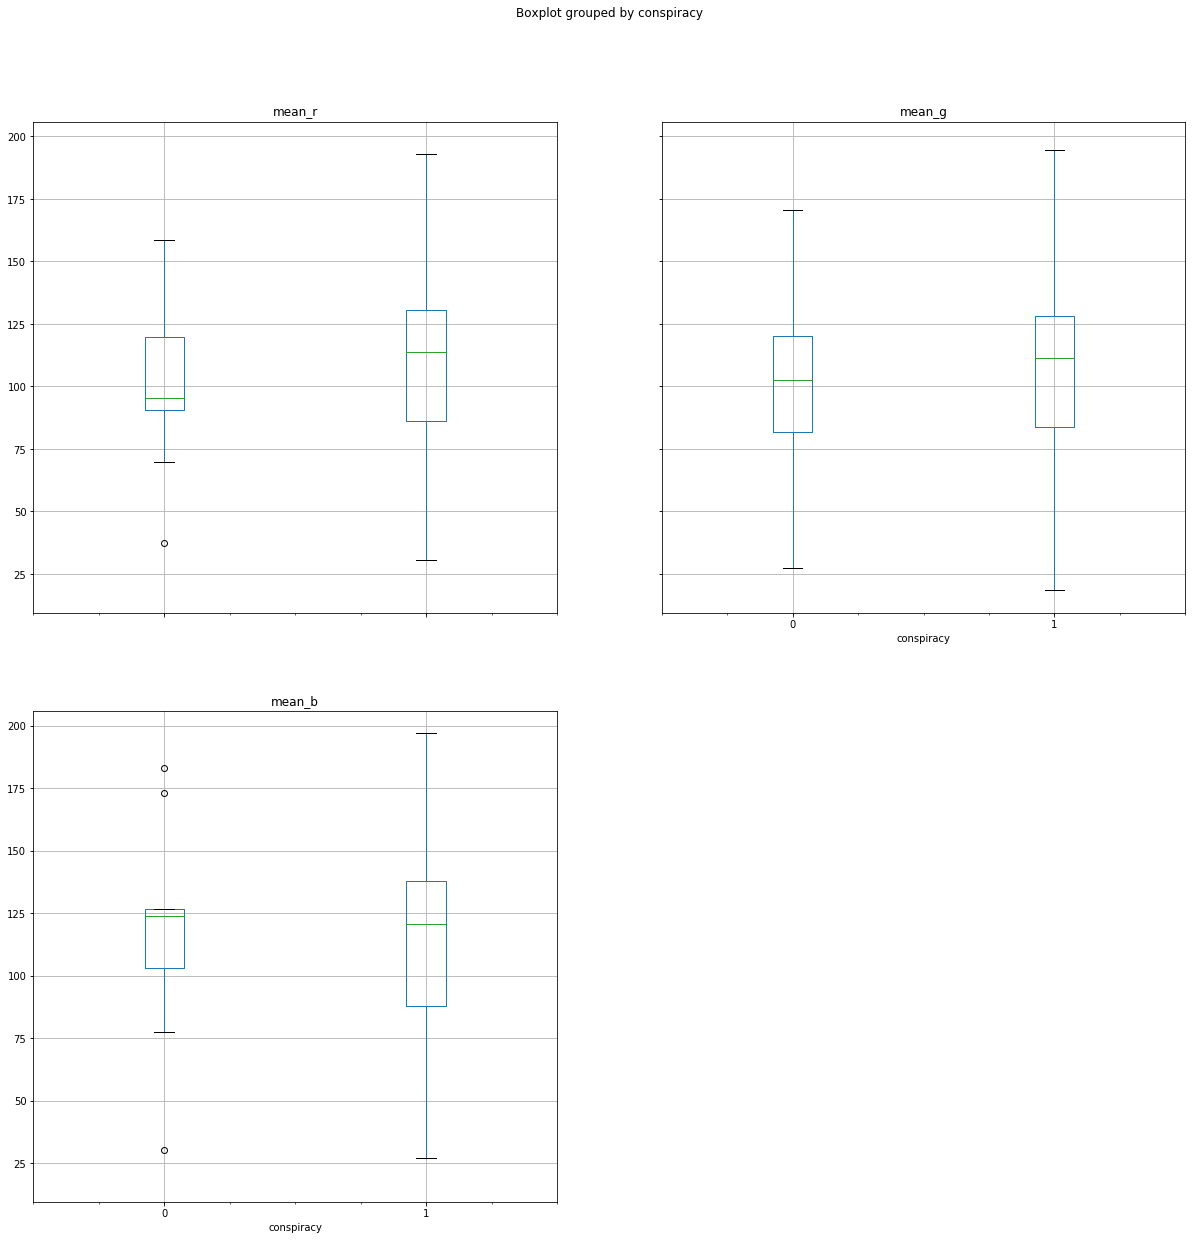

In [25]:
design_matrix['conspiracy'] = design_matrix['conspiracy'].astype('category')
design_matrix['mean_r'] = design_matrix['mean_r'].astype('float')
design_matrix['mean_g'] = design_matrix['mean_g'].astype('float')
design_matrix['mean_b'] = design_matrix['mean_b'].astype('float')
design_matrix['var_r'] = design_matrix['var_r'].astype('float')
design_matrix['var_g'] = design_matrix['var_g'].astype('float')
design_matrix['var_b'] = design_matrix['var_b'].astype('float')



design_matrix.boxplot(column=['mean_r','mean_g','mean_b'],by='conspiracy',figsize=(20,20))
plt.savefig("pilot_mean.pdf", format="pdf")

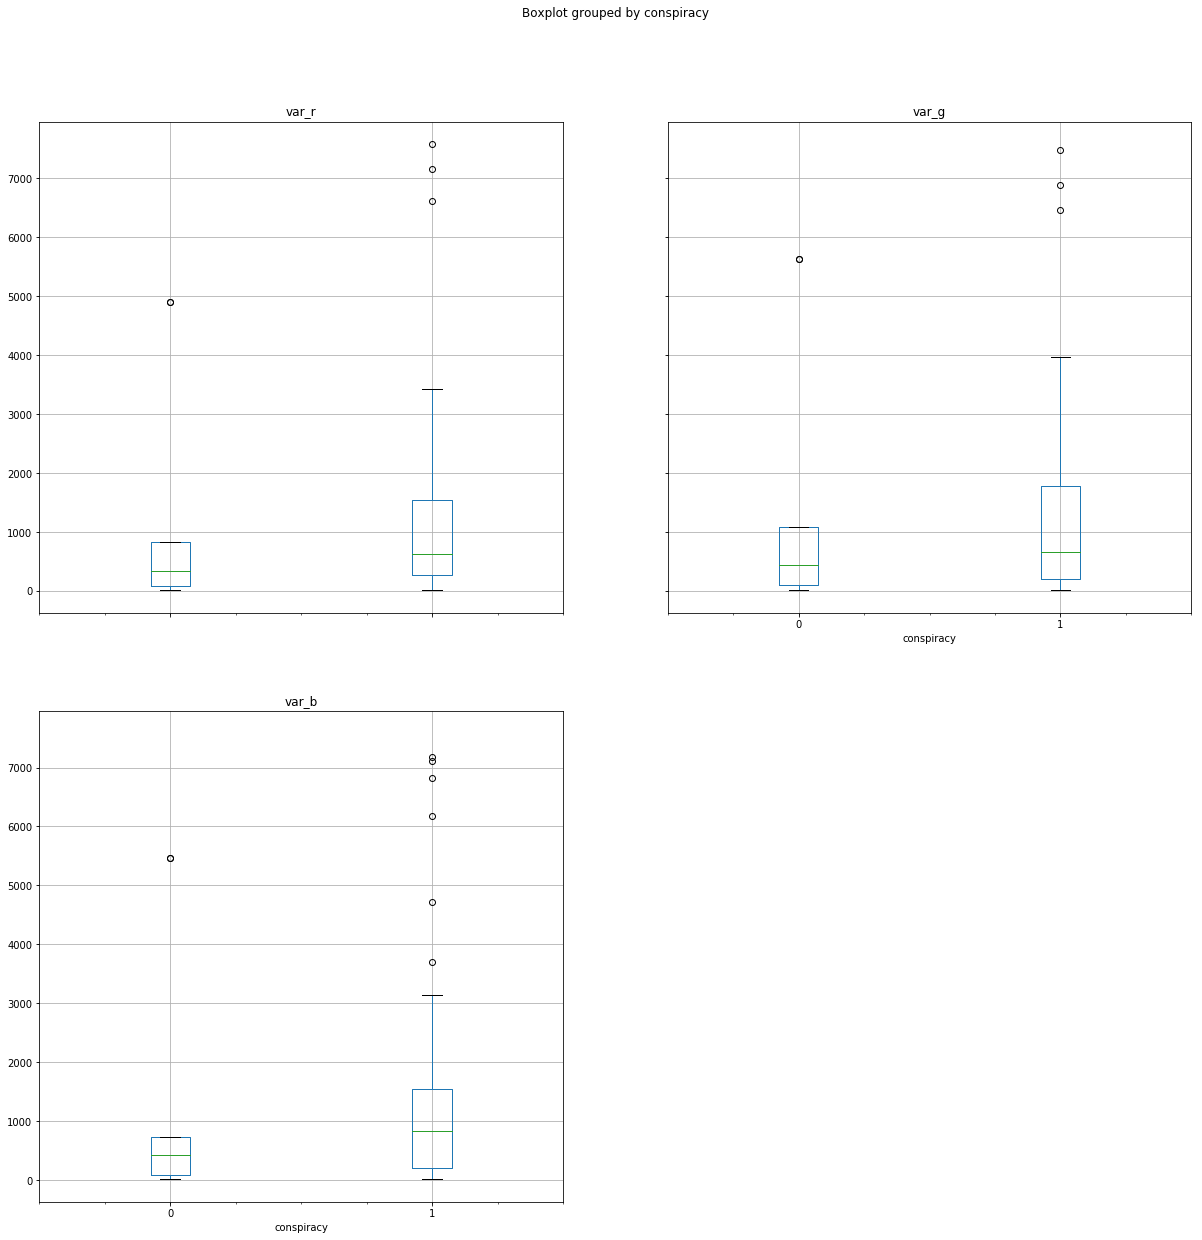

In [26]:
design_matrix.boxplot(column=['var_r','var_g','var_b'],by='conspiracy',figsize=(20,20))
plt.savefig("pilot_variance.pdf", format="pdf")

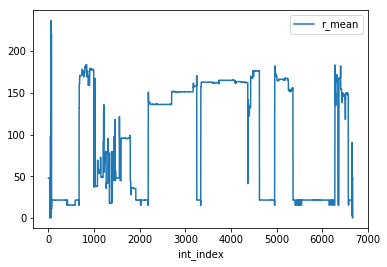

In [48]:
import matplotlib.pyplot as plt
# df.plot(x="frame", y=['r_mean', 'g_mean', 'b_mean','r_median', 'g_median', 'b_median',
#                                                 'hue_mean', 'sat_mean', 'val_mean','hue_median', 'sat_median', 'val_median'])
df = df.sort_values(by=['frame'])
df['int_index'] = range(len(df))
df.plot(x="int_index", y=['r_mean'])

df.drop('int_index', axis=1, inplace=True)
plt.show()

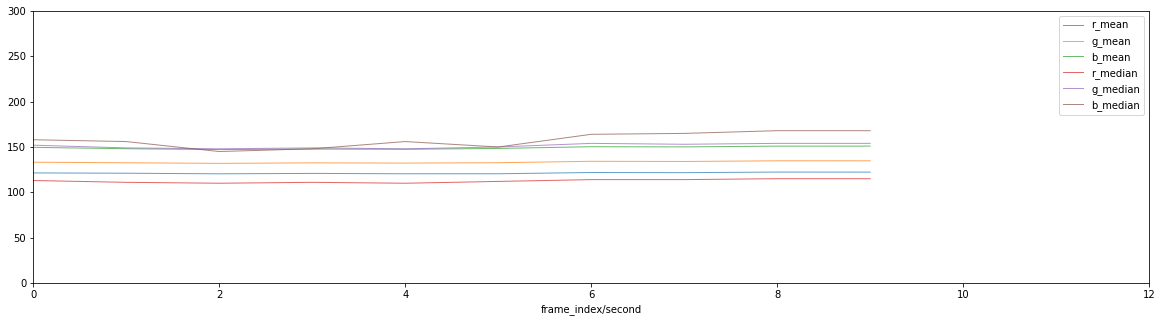

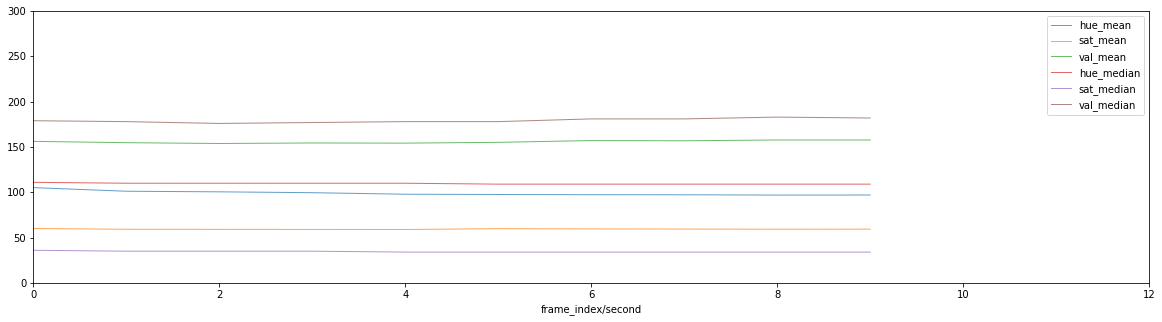

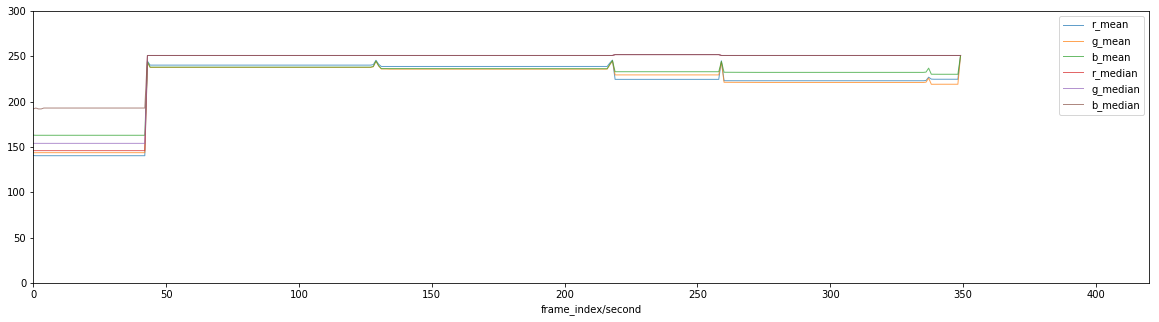

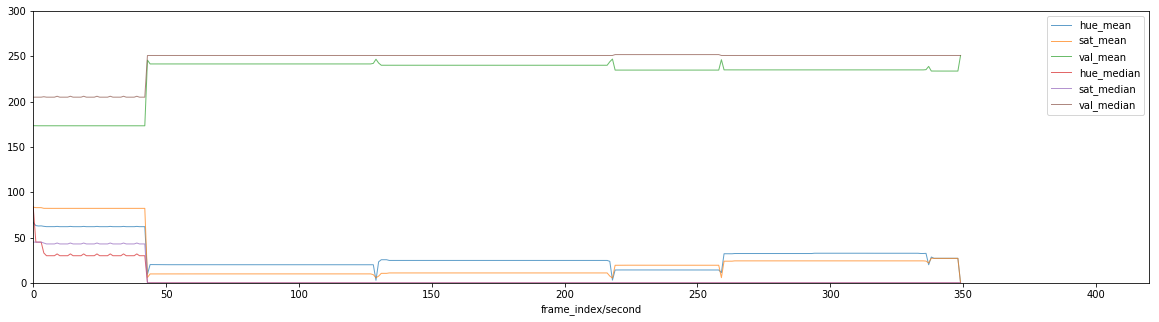

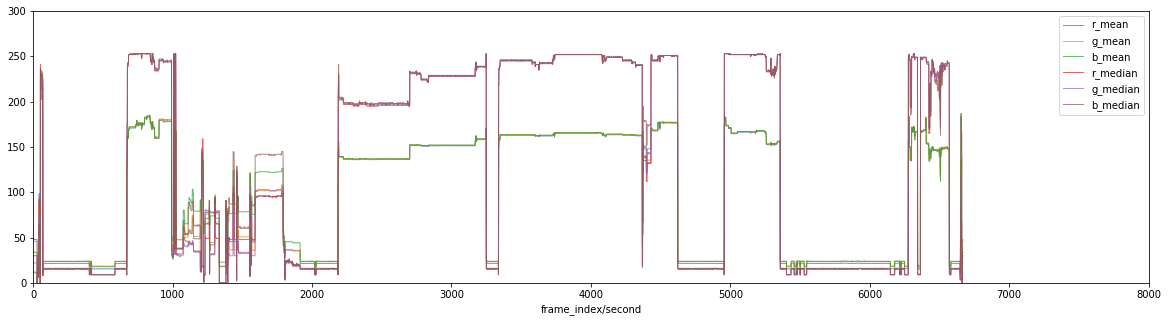

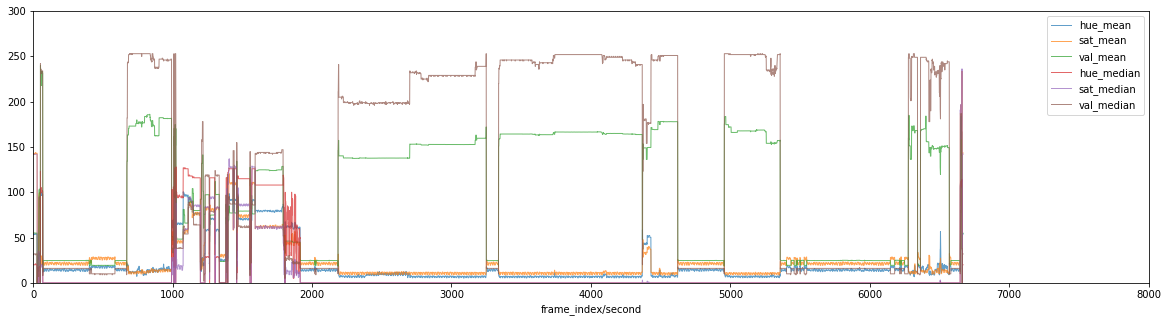

In [83]:
from numpy import arange
for key, vid in dictOfStuff.items():
    if not vid.empty:
        vid = vid.sort_values(by=['frame'])
        vid['frame_index'] = range(len(vid))
#         plt.figure(f)
        vid.plot(x="frame_index", y=['r_mean', 'g_mean', 'b_mean','r_median', 'g_median', 'b_median'],linewidth = 1, alpha=0.7,figsize = (20,5))
        #         print(len(vid))
        
        plt.xlim([0, 1.2 * len(vid)])
        plt.ylim([0, 300])
        plt.xlabel('frame_index/second')
        plt.savefig( 'rgb'+ str(len(vid))+'_'+ key + '.pdf')
        plt.show()
        
        vid.plot(x="frame_index", y=['hue_mean', 'sat_mean', 'val_mean','hue_median', 'sat_median', 'val_median'],
                                 linewidth = 1, alpha=0.7,figsize = (20,5))
        #         print(len(vid))
        plt.xlim([0, 1.2 * len(vid)])
        plt.ylim([0, 300])
        plt.xlabel('frame_index/second')
        plt.savefig('hsv'+ str(len(vid))+'_'+ key + '.pdf')
        

        plt.show()
        
        

In [22]:
hsv_nemo = cv2.cvtColor(nemo, cv2.COLOR_RGB2HSV)

AttributeError: 'numpy.ndarray' object has no attribute 'convert'

In [25]:
img = cv2.imread("./images/olGYGmIBedw/frame125.jpg")

In [29]:
rgb_mean = img.reshape(-1,3).mean(axis = 0)
rgb_median = np.median(img.reshape(-1,3),axis = 0)

In [31]:
rgb_median

array([147., 156., 194.])

In [32]:
hsv_img = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)

In [35]:
hsv_mean = hsv_img.reshape(-1,3).mean(axis = 0)
hsv_median = np.median(hsv_img.reshape(-1,3),axis = 0)

In [37]:
hsv_mean

array([ 30.,  44., 208.])

In [38]:
hsv_mean

array([ 61.65499132,  84.37317708, 173.58034288])

In [39]:
np.concatenate((hsv_mean, rgb_median), axis=None)

array([ 61.65499132,  84.37317708, 173.58034288, 147.        ,
       156.        , 194.        ])

In [11]:
file_list = os.listdir("./images/sEXlAvG-cJc")
file_list

['frame150.jpg',
 'frame90.jpg',
 'frame180.jpg',
 'frame30.jpg',
 'frame120.jpg',
 'frame240.jpg',
 'frame270.jpg',
 'frame300.jpg',
 'frame210.jpg',
 'frame60.jpg']

In [12]:
sorted(file_list)

['frame120.jpg',
 'frame150.jpg',
 'frame180.jpg',
 'frame210.jpg',
 'frame240.jpg',
 'frame270.jpg',
 'frame30.jpg',
 'frame300.jpg',
 'frame60.jpg',
 'frame90.jpg']

In [33]:
frame('frame120.jpg')

120

In [34]:
sorted(file_list, key = frame)

['frame30.jpg',
 'frame60.jpg',
 'frame90.jpg',
 'frame120.jpg',
 'frame150.jpg',
 'frame180.jpg',
 'frame210.jpg',
 'frame240.jpg',
 'frame270.jpg',
 'frame300.jpg']